In [1]:
%pip install --quiet -U langgraph langchain_groq langgraph_sdk langgraph-prebuilt langchain-community wikipedia trustcall

In [2]:
import os
import sqlite3
from google.colab import userdata

api_key = userdata.get("groq_api_key")
os.environ["GROQ_API_KEY"] = api_key
os.environ["LANGCHAIN_TRACKING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="langchain-academy"

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=1.0,
    model_name="llama3-8b-8192",
    verbose=True
)

In [4]:
from pydantic import BaseModel,Field
class Memory(BaseModel):
  """Represents a single fact or memory about the user."""
  content :str=Field(description="the main content of the memory. For example user expressed interest in learning about french")

class MemoryCollection(BaseModel):
  memories:list[Memory]=Field(description="A list of memory about the user")

In [5]:
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_groq import ChatGroq

model_with_stucture=llm.with_structured_output(MemoryCollection)
memory_cllection=model_with_stucture.invoke([HumanMessage("My name is khuram . I like to play cricket")])
memory_cllection.memories

[Memory(content='khuram'), Memory(content='cricket')]

In [6]:
memory_cllection.memories[0].model_dump()

{'content': 'khuram'}

In [7]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store=InMemoryStore()
user_id="1"
namespace_for_mmeory=(user_id,"memories")
key=str(uuid.uuid4)
value=memory_cllection.memories[0].model_dump()
in_memory_store.put(namespace_for_mmeory,key,value)

In [8]:
for m in in_memory_store.search(namespace_for_mmeory):
  print(m.dict)

<bound method SearchItem.dict of Item(namespace=['1', 'memories'], key='<function uuid4 at 0x7e4dd27aaac0>', value={'content': 'khuram'}, created_at='2025-08-20T22:19:59.560872+00:00', updated_at='2025-08-20T22:19:59.560876+00:00', score=None)>


In [9]:
from trustcall import create_extractor
trustcall_extractor=create_extractor(
    llm,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [10]:
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
instructiom="""Extract the meories fromm  the following converstaion"""
conversation=[HumanMessage(content="I am khuram"),
              AIMessage(content="Hello khuram how are you"),
              HumanMessage(content="This morning i had a nice bike ride in islamabad")]

result=trustcall_extractor.invoke({"messages":[SystemMessage(content=instructiom)]+conversation})

In [11]:
for m in result["messages"]:
  m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (rmrq1ga5s)
 Call ID: rmrq1ga5s
  Args:
    content: Had a nice bike ride in Islamabad this morning.


In [12]:
for m in result["responses"]:
  print(m)

content='Had a nice bike ride in Islamabad this morning.'


In [13]:
for m in result["response_metadata"]:
  print(m)

{'id': 'rmrq1ga5s'}


In [14]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"),
                        HumanMessage(content="I went to cheszious and ate a pizza."),
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my RYK, and going back next week!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Had a nice bike ride in Islamabad this morning.'})]

In [15]:
result = trustcall_extractor.invoke({"messages": updated_conversation,
                                     "existing": existing_memories})

ERROR:extraction:Could not apply patch: member 'instance' not found in {'content': 'Had a nice bike ride in Islamabad this morning.'}


In [16]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================


In [17]:
for m in result["responses"]:
    print(m)

In [18]:
for m in result["response_metadata"]:
    print(m)

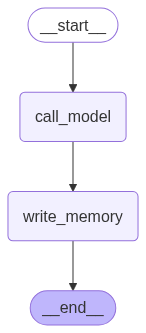

In [19]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    llm,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user.

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation):

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction.

Use the provided tools to retain any necessary memories about the user.

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages,
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Nice to meet you, Lance! I'm happy to be chatting with you today. Since we're just starting out, my current memory about you is that your name is Lance. Would you like to share a bit more about yourself or is there something specific you'd like to talk about or ask?


BadRequestError: Error code: 400 - {'error': {'message': "'tools.0.function.description' : Value is not nullable", 'type': 'invalid_request_error'}}

In [ ]:
# User input
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())